---
#nolearn을 이용한 Python CNN 튜토리얼
---

 - 출처 : http://nbviewer.jupyter.org/github/dnouri/nolearn/blob/master/docs/notebooks/CNN_tutorial.ipynb

## Imports

- 필요한 모듈 import

In [2]:
import os

In [3]:
# 시각화를 위한 matplotlib
import matplotlib.pyplot as plt
%pylab inline
# 데이터 핸들링을 위한 numpy
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [4]:
# CNN 레이어를 위한 lasagne 
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Conv2DLayer
from lasagne.layers import MaxPool2DLayer
from lasagne.nonlinearities import softmax
from lasagne.updates import adam
from lasagne.layers import get_all_params

In [5]:
# NN 모델링을 위한 nolearn
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import TrainSplit
from nolearn.lasagne import objective

- Note: If your GPU supports it, you should try using lasagne.cuda_convnet.Conv2DCCLayer and lasagne.cuda_convnet.MaxPool2DCCLayer, which could give you a nice speed up.

## 1. Loading MNIST data

![ d](http://pavel.surmenok.com/wp-content/uploads/2014/07/mnistdigits.gif)

- [MNIST data](https://en.wikipedia.org/wiki/MNIST_database) : 0~9를 수기로 작성한 이미지.
- MNIST data를 읽어옴.
- 데이터는 여기서 -> https://www.kaggle.com/c/digit-recognizer/data

In [137]:
# MNIST 데이터가 있는 파일경로(path)설정.
path = os.path.join('train.csv') #상대경로
# path = os.path.join(os.path.expanduser('~'), 'data/mnist/train.csv') # 절대경로 할때는 이렇게!

In [138]:
X = []
y = []

In [139]:
# 위에서 지정한 경로의 파일 오픈
with open(path, 'rb') as f:
    next(f)  # skip header
    for line in f:
        yi, xi = line.split(',', 1) # 'a,b,c,d' -> ['a','b,c,d'] : 첫번째 ','에서만 split
        y.append(yi) # 이미지의 라벨
        X.append(xi.split(',')) # 이미지 데이터 (28x28에 0~255값이 있는 것이 42000개 있음.)

In [140]:
# Theano works with fp32 precision
X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.int32)

In [141]:
X[0]  # 28x28에 0~255

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,

In [142]:
# apply some very simple normalization to the data
X -= X.mean()
X /= X.std()

In [144]:
X[0]

array([-0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
       -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
       -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
       -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
       -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
       -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
       -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
       -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
       -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
       -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
       -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
       -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
       -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
       -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42

In [146]:
# convolutional layers를 위해 데이터를 bc01형태로 변형해야함.
# bc01 = batch size x color channels x image dimension 1 x image dimension 2.
# Therefore, we reshape the X data to -1, 1, 28, 28.
X = X.reshape(
    -1,  # number of samples, -1 makes it so that this number is determined automatically
    1,   # 1 color channel, since images are only black and white
    28,  # first image dimension (vertical)
    28,  # second image dimension (horizontal)
)

In [151]:
X[0] # 28x28 매트릭스 형태로 변환됨.

array([[[-0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
         -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
         -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
         -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
         -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
         -0.42462987, -0.42462987, -0.42462987],
        [-0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
         -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
         -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
         -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
         -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
         -0.42462987, -0.42462987, -0.42462987],
        [-0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
         -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
         -0.42

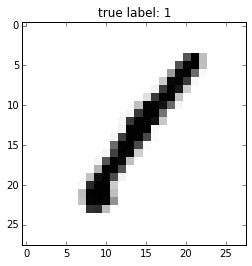

In [165]:
plt.imshow(X[0][0], cmap='Greys',  interpolation='nearest')
plt.title('true label: %d' % y[0])

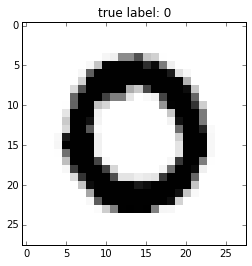

In [166]:
plt.imshow(X[1][0], cmap='Greys',  interpolation='nearest')
plt.title('true label: %d' % y[1])

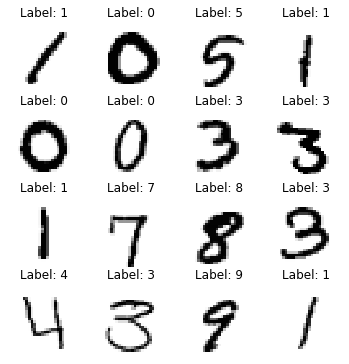

In [167]:
figs, axes = plt.subplots(4, 4, figsize=(6, 6))
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(-X[i + 4 * j].reshape(28, 28), cmap='gray', interpolation='none')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_title("Label: {}".format(y[i + 4 * j]))
        axes[i, j].axis('off')

In [174]:
X.shape[3]

28

## 2. Definition of the layers

- CNN의 레이어를 정의하는 단계.
- Lasagne의 레이어를 이용.
- 일반적으로 레이어는 하나의 list 형태, list의 각각의 요소(NN의 옵션값)는 tuple로 정의됨. 
- [Lasagne의 레이어 종류](http://lasagne.readthedocs.org/en/latest/modules/layers.html)
- 본 실습에 사용된 레이어
    - __InputLayer : holds a symbolic variable that represents a network input. __  
        - batch size x color channels x image dimension 1 x image dimension 2 (aka bc01)
    - __Conv2DLayer : 2D convolutional layer.__  
        - num_filters : 채널의 수. (더 많이 선택될수록 CNN으로 더 다양한 필터가 학습될수있음.)   
        - filter_size : 필터/커널의 사이즈. (3이면, 3x3 필터)
    - __MaxPool2DLayer : 2D max-pooling layer.__   
        - pool_size : 풀의 사이즈.
    - __DenseLayer : vanilla fully-connected layer __   
        - num_units : 지정된 뉴런의 수.
        - 마지막에 오면 output layer의 역할.
    - __DropoutLayer : common technique to regularize neural networks__  
        - dense layer 사이에 오는것이 좋음!

In [175]:
layers0 = [
    # layer dealing with the input data
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}),
    
    # first stage of our convolutional layers
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 5}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (MaxPool2DLayer, {'pool_size': 2}),

    # second stage of our convolutional layers
    (Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (MaxPool2DLayer, {'pool_size': 2}),

    # two dense layers with dropout
    (DenseLayer, {'num_units': 64}),
    (DropoutLayer, {}),
    (DenseLayer, {'num_units': 64}),

    # the output layer
    (DenseLayer, {'num_units': 10, 'nonlinearity': softmax}),
]

## 3. Definition of the neural network

- NN을 정의.

In [201]:
# L2 regularization을 함.
def regularization_objective(layers, lambda1=0., lambda2=0., *args, **kwargs):
    # default loss
    losses = objective(layers, *args, **kwargs)
    # get the layers' weights, but only those that should be regularized
    # (i.e. not the biases)
    weights = get_all_params(layers[-1], regularizable=True)
    # sum of absolute weights for L1
    sum_abs_weights = sum([abs(w).sum() for w in weights])
    # sum of squared weights for L2
    sum_squared_weights = sum([(w ** 2).sum() for w in weights])
    # add weights to regular loss
    losses += lambda1 * sum_abs_weights + lambda2 * sum_squared_weights
    return losses

In [60]:
net0 = NeuralNet(
    # Layer 지정.
    layers=layers0, # 앞에서 만든 레이어.
    
    # 얼마나 반복하여 학습시킬지. (모든 training data의 full training cycle을 epoch이라고 함.)
    max_epochs=10, 

    # we choose adam, which for many problems is a good first choice as updateing rule.
    update=adam,
    update_learning_rate=0.0002,

    # objective를 위에서 정의한 
    objective=regularization_objective,
    objective_lambda2=0.0025,

    train_split=TrainSplit(eval_size=0.25),
    
    # verbose를 1로 설정하면, 학습하는 동안 유용한 정보를 줌.
    verbose=1,
)

## Training the neural network

- verbose를 1로 설정했기 때문에 학습하는 동안 정보를 줌.
- 가장 먼저 NN의 각 레이어에 대한 정보가 출력되고, 학습하는 동안 각 epoch마다 정보를 출력.
- train loss : the loss/cost that the net tries to minimize. (여기서는 log loss)
- valid loss : the loss for the hold out validation set.
- train/val : ratio of train loss to valid loss. __(이 수치가 작으면, train data에 overfit된것.)__
- valid acc : the accuracy score of the valdation set.
- dur : 각 epoch의 학습 시간

In [65]:
import time
start = time.time()
net0.fit(X, y)
end = time.time()
print end-start

# Neural Network with 753610 learnable parameters

## Layer information

  #  name         size
---  -----------  --------
  0  input0       1x28x28
  1  conv2d1      96x24x24
  2  conv2d2      96x22x22
  3  conv2d3      96x20x20
  4  conv2d4      96x18x18
  5  conv2d5      96x16x16
  6  maxpool2d6   96x8x8
  7  conv2d7      128x6x6
  8  conv2d8      128x4x4
  9  conv2d9      128x2x2
 10  maxpool2d10  128x1x1
 11  dense11      64
 12  dropout12    64
 13  dense13      64
 14  dense14      10

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -------
      1       1.67597       1.22998      1.36260      0.94974  985.74s
      2       1.24615       1.03553      1.20339      0.96781  986.91s
      3       1.05601       0.91399      1.15539      0.97383  1025.63s
      4       0.92815       0.83796      1.10764      0.97336  1022.49s
      5       0.83691       0.74275      1.12677      0.98052  982.46s
      6

In [74]:
print str(10019/60) + "분 걸림.. ㄷㄷ"

166분 걸림.. ㄷㄷ


## 4. Visualizations

- NN의 결과의 이상유무를 파악하는 것은 어려움.
- nolearn의 시각화 툴을 이용하면 NN의 이상을 쉽게 판단할수있음.

In [169]:
from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion

### Train and validation loss progress

<module 'matplotlib.pyplot' from '/Users/Chad/Desktop/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

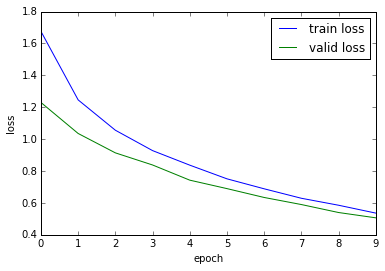

In [202]:
plot_loss(net0)

This kind of visualization can be helpful in determining whether we want to continue training or not. For instance, here we see that both loss functions still are still decreasing and that more training will pay off. This graph can also help determine if we are overfitting: If the train loss is much lower than the validation loss, we should probably do something to regularize the net.

### Visualizing layer weights

We can further have a look at the weights learned by the net. The first argument of the function should be the layer we want to visualize. The layers can be accessed through the layers_ attribute and then by name (e.g. 'conv2dcc1') or by index, as below. (Obviously, visualizing the weights only makes sense for convolutional layers.)

<module 'matplotlib.pyplot' from '/Users/Chad/Desktop/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

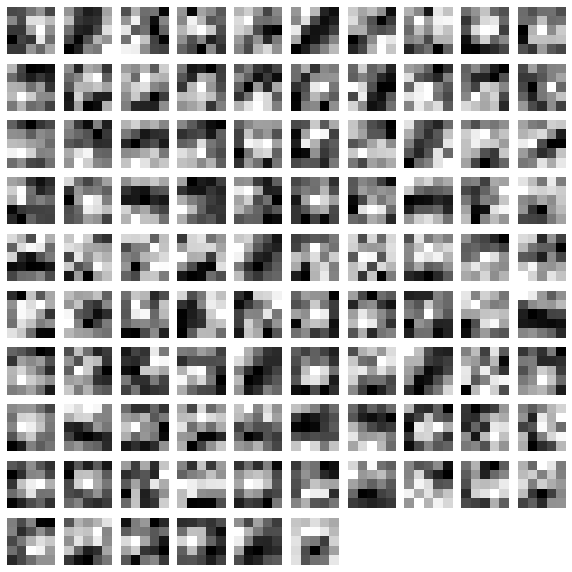

In [222]:
plot_conv_weights(net0.layers_[1], figsize=(10, 10))

- 레이어 정의할때, Conv2DLayer의 num_filters를 96으로 설정해서 96개의 필터.
- As can be seen above, in our case, the results are not too interesting. If the weights just look like noise, we might have to do something (e.g. use more filters so that each can specialize better).

## Visualizing the layers' activities

- To see through the "eyes" of the net, we can plot the activities produced by different layers. 

In [219]:
x = X[0:1]

In [220]:
x

array([[[[-0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
          -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
          -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
          -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
          -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
          -0.42462987, -0.42462987, -0.42462987],
         [-0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
          -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
          -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
          -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
          -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
          -0.42462987, -0.42462987, -0.42462987],
         [-0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,
          -0.42462987, -0.42462987, -0.42462987, -0.42462987, -0.42462987,


<module 'matplotlib.pyplot' from '/Users/Chad/Desktop/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

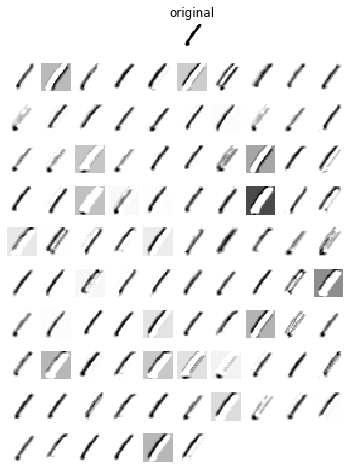

In [221]:
plot_conv_activity(net0.layers_[1], x)
# the first argument, again, is a layer.
# the second argument an image in the bc01 format (which is why we use X[0:1] instead of just X[0]).

- Here we can see that depending on the learned filters, the neural net represents the image in different ways, which is what we should expect.
- If some images were completely black, that could indicate that the corresponding filters have not learned anything useful. 
- When you find yourself in such a situation, training longer or initializing the weights differently might do the trick.

### Plot occlusion images

- If the most critical part of an image is something like the head of a person, that is probably right.
- If it is instead a random part of the background, the net probably overfits -> [참고자료](http://www.matthewzeiler.com/pubs/arxive2013/arxive2013.pdf)

<module 'matplotlib.pyplot' from '/Users/Chad/Desktop/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

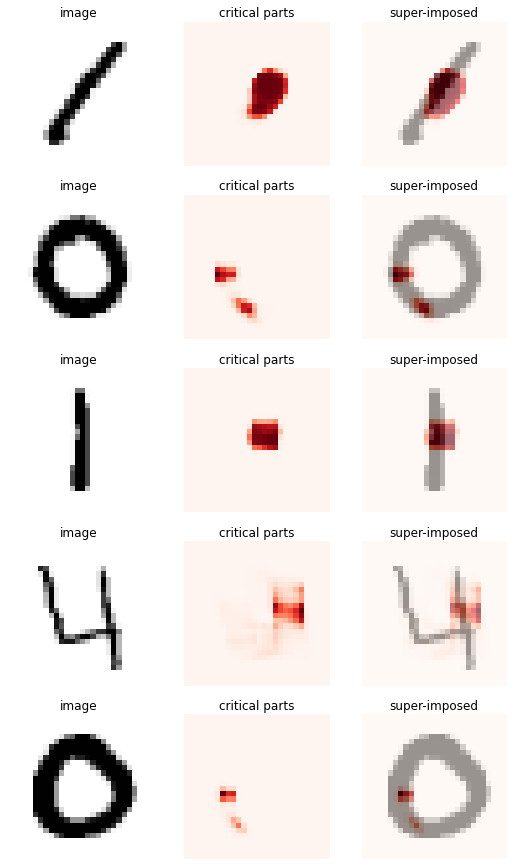

In [179]:
plot_occlusion(net0, X[:5], y[:5])

- which parts of the number are most important for correct classification. 
- 복잡한 이미지일때 더 유용함.